Estimated transformation matrix (mm):
 [[ 6.51415524e-04  7.08227142e-07 -2.79298285e+00]
 [-8.09794937e-08 -6.50497790e-04  2.11260388e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
New transformation matrix (pixels):
 [[ 6.51415524e-01  7.08227142e-04 -2.79298285e+03]
 [-8.09794937e-05 -6.50497790e-01  2.11260388e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Transformed corners (pixels): [[-2792.98284705 21126.03880935]
 [15290.31210632 21123.7908186 ]
 [15317.74882579 -4076.49355625]
 [-2765.54612758 -4074.2455655 ]]
Bounding box: [-2792.98284705 -4076.49355625] [15317.74882579 21126.03880935]
Output shape (pixels): 18111 x 25203
Final transformation matrix (pixels):
 [[ 6.51415524e-01  7.08227142e-04  0.00000000e+00]
 [-8.09794937e-05 -6.50497790e-01  2.52025324e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
High-resolution warped image saved to: /Users/katherineridley/Projects/CosMx/APP/B1_warped_highres.tif
Transformation matrix saved to A2_transfor

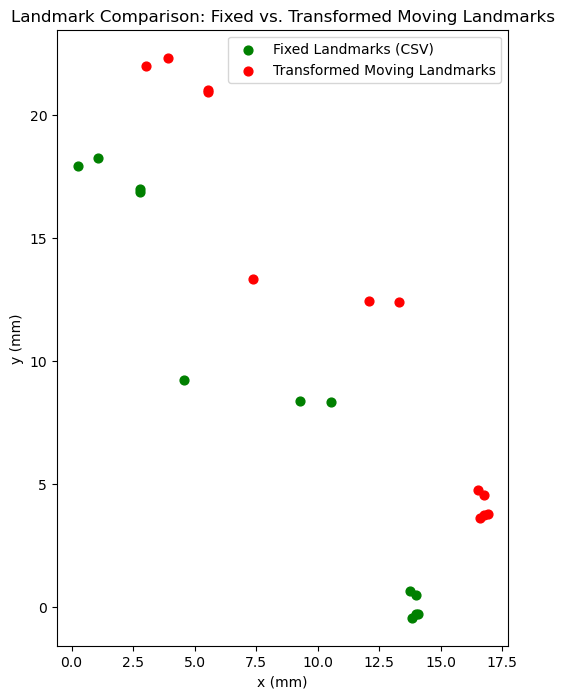

In [12]:
import pandas as pd
import numpy as np
from skimage import io, transform
import tifffile

# 1. Read landmarks CSV (landmarks in mm)
landmarks = pd.read_csv("/Users/katherineridley/Projects/CosMx/APP/B1_landmarks_manual.csv")
src = np.column_stack((landmarks['x_moving'].values, landmarks['y_moving'].values))
dst = np.column_stack((landmarks['x_fixed'].values, landmarks['y_fixed'].values))

# 2. Estimate the affine transformation (from moving to fixed, in mm)
tform = transform.estimate_transform('affine', src, dst)
print("Estimated transformation matrix (mm):\n", tform.params)

# 3. Define the desired output resolution in the fixed space.
# For high resolution, e.g., 1000 pixels per mm.
pixels_per_mm_fixed = 1000

# 4. Define the fixed coordinate extents (in mm).
fixed_x_min = landmarks['x_fixed'].min()
fixed_x_max = landmarks['x_fixed'].max()
fixed_y_min = landmarks['y_fixed'].min()
fixed_y_max = landmarks['y_fixed'].max()
fixed_width_mm = fixed_x_max - fixed_x_min
fixed_height_mm = fixed_y_max - fixed_y_min

# 5. Scale the transformation so that the fixed units are in pixels.
S = np.array([[pixels_per_mm_fixed, 0, 0],
              [0, pixels_per_mm_fixed, 0],
              [0, 0, 1]])
T_new = S @ tform.params  # New transformation from moving image pixels to fixed pixels.
print("New transformation matrix (pixels):\n", T_new)

# Create an AffineTransform for convenience.
tform_new = transform.AffineTransform(matrix=T_new)

# 6. Load the moving image.
moving_image_path = "/Users/katherineridley/Projects/CosMx/APP/B1_flipped_rotated.tif"
moving_image = tifffile.imread(moving_image_path)

# 7. Compute the bounding box of the transformed moving image.
# Get the corners of the moving image.
h, w = moving_image.shape[:2]
corners = np.array([
    [0, 0],
    [w, 0],
    [w, h],
    [0, h]
])
# Transform these corners using tform_new.
transformed_corners = tform_new(corners)
min_coords = transformed_corners.min(axis=0)
max_coords = transformed_corners.max(axis=0)
print("Transformed corners (pixels):", transformed_corners)
print("Bounding box:", min_coords, max_coords)

# 8. Compute the output shape as the size of the bounding box.
output_width = int(np.ceil(max_coords[0] - min_coords[0]))
output_height = int(np.ceil(max_coords[1] - min_coords[1]))
print("Output shape (pixels):", output_width, "x", output_height)

# 9. Because the transformation computed above maps moving image coordinates to fixed image pixel coordinates,
# we need to adjust the transformation so that the output image's coordinate system starts at (0, 0).
# Compute a translation that shifts min_coords to 0.
shift = np.array([[1, 0, -min_coords[0]],
                  [0, 1, -min_coords[1]],
                  [0, 0, 1]])
T_final = shift @ T_new  # Compose the shift with T_new.
tform_final = transform.AffineTransform(matrix=T_final)
print("Final transformation matrix (pixels):\n", T_final)

# 10. Warp the moving image using the final transformation.
warped_image = transform.warp(
    moving_image,
    inverse_map=tform_final.inverse,
    output_shape=(output_height, output_width),
    preserve_range=True
)
warped_image = warped_image.astype(moving_image.dtype)

# 11. Save the high-resolution warped image.
output_warped_path = "/Users/katherineridley/Projects/CosMx/APP/B1_warped_highres.tif"
tifffile.imwrite(output_warped_path, warped_image)
print("High-resolution warped image saved to:", output_warped_path)

# 12. Save the final transformation matrix for future use.
np.savetxt("/Users/katherineridley/Projects/CosMx/APP/B1_transform_matrix.csv", T_final, delimiter=",")
print("Transformation matrix saved to A2_transform_matrix.csv")

# Assuming from your earlier code:
#   - `src` is an array of moving landmarks (from your CSV) in moving image pixel units.
#   - `dst` is an array of fixed landmarks in mm (from your CSV).
#   - T_final is your final transformation matrix (from step 9) that maps moving image coordinates
#     to fixed coordinates in pixel units.
#   - pixels_per_mm_fixed is the scale factor used (e.g., 1000 fixed pixels per mm).

pixels_per_mm_fixed = 1000  # Make sure this is the same value used when scaling the transformation

# 13. Transform the moving landmarks using T_final.
# Convert src to homogeneous coordinates.
ones = np.ones((src.shape[0], 1))
src_homog = np.hstack([src, ones])
# Apply the transformation matrix T_final.
transformed_landmarks_pixels = (T_final @ src_homog.T).T  # shape (N, 3)
# Convert from fixed pixels to mm by dividing the x and y coordinates.
transformed_landmarks_mm = transformed_landmarks_pixels[:, :2] / pixels_per_mm_fixed

# 14. Save the transformed landmarks to CSV.
df_transformed = pd.DataFrame(transformed_landmarks_mm, columns=["x_transformed_mm", "y_transformed_mm"])
output_landmarks_csv = "/Users/katherineridley/Projects/CosMx/APP/B1_transformed_landmarks.csv"
df_transformed.to_csv(output_landmarks_csv, index=False)
print("Transformed landmarks saved to:", output_landmarks_csv)

# 15. Plot the landmark comparison.
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
# Plot the fixed landmarks from your CSV (assumed to be in mm)
plt.scatter(dst[:, 0], dst[:, 1], color='green', label='Fixed Landmarks (CSV)', s=40)
# Plot the transformed moving landmarks (converted to mm)
plt.scatter(transformed_landmarks_mm[:, 0], transformed_landmarks_mm[:, 1], color='red', label='Transformed Moving Landmarks', s=40)
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.title("Landmark Comparison: Fixed vs. Transformed Moving Landmarks")
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()



Estimated transformation matrix (mm):
 [[ 6.51559489e-04  2.11194665e-06 -5.24298016e-01]
 [ 3.70979787e-07 -6.50120219e-04  2.38013487e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
New transformation matrix (pixels):
 [[ 6.51559489e-01  2.11194665e-03 -5.24298016e+02]
 [ 3.70979787e-04 -6.50120219e-01  2.38013487e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Initial final transformation matrix (pixels):
 [[ 6.51559489e-01  2.11194665e-03  0.00000000e+00]
 [ 3.70979787e-04 -6.50120219e-01  2.51856573e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Average offset (mm): [-0.52429802 -1.38430862]
Average offset (pixels): [ -524.29801552 -1384.30861929]
Corrected transformation matrix (pixels):
 [[ 6.51559489e-01  2.11194665e-03 -5.24298016e+02]
 [ 3.70979787e-04 -6.50120219e-01  2.38013487e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Transformation matrix saved to B1_transform_matrix_corrected.csv
Corrected transformed landmarks saved to: /Users/

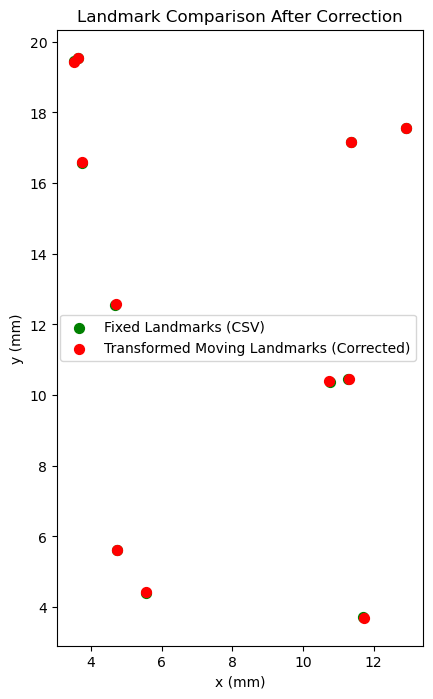

In [15]:
import pandas as pd
import numpy as np
from skimage import io, transform
import tifffile

# Assume these are already defined:
# landmarks CSV, tform, T_new, T_final, pixels_per_mm_fixed, src, dst
# For clarity, we'll re-read and recompute parts here.

# 1. Read landmarks CSV
landmarks = pd.read_csv("/Users/katherineridley/Projects/CosMx/APP/A2_landmarks_manual.csv")
src = np.column_stack((landmarks['x_moving'].values, landmarks['y_moving'].values))
dst = np.column_stack((landmarks['x_fixed'].values, landmarks['y_fixed'].values))

# 2. Estimate the affine transformation (from moving to fixed, in mm)
tform = transform.estimate_transform('affine', src, dst)
print("Estimated transformation matrix (mm):\n", tform.params)

# 3. Use your chosen scale: e.g., 1000 pixels per mm.
pixels_per_mm_fixed = 1000

# 4. Scale the transformation matrix to fixed pixels:
S = np.array([[pixels_per_mm_fixed, 0, 0],
              [0, pixels_per_mm_fixed, 0],
              [0, 0, 1]])
T_new = S @ tform.params
print("New transformation matrix (pixels):\n", T_new)



# Load the moving image to get its dimensions:
moving_image_path = "/Users/katherineridley/Projects/CosMx/APP/A2_flipped_rotated.tif"
moving_image = tifffile.imread(moving_image_path)
h, w = moving_image.shape[:2]
corners = np.array([[0, 0], [w, 0], [w, h], [0, h]])
tform_new = transform.AffineTransform(matrix=T_new)
transformed_corners = tform_new(corners)
min_coords = transformed_corners.min(axis=0)
max_coords = transformed_corners.max(axis=0)
shift = np.array([[1, 0, -min_coords[0]],
                  [0, 1, -min_coords[1]],
                  [0, 0, 1]])
T_final = shift @ T_new
print("Initial final transformation matrix (pixels):\n", T_final)

# 6. Compute transformed landmarks using T_final.
n = src.shape[0]
src_homog = np.hstack([src, np.ones((n, 1))])
transformed_landmarks_pixels = (T_final @ src_homog.T).T  # shape (N,3)
# Convert to mm:
transformed_landmarks_mm = transformed_landmarks_pixels[:, :2] / pixels_per_mm_fixed

# 7. Compute average offset between fixed landmarks (dst) and transformed moving landmarks.
offset_mm = dst.mean(axis=0) - transformed_landmarks_mm.mean(axis=0)
print("Average offset (mm):", offset_mm)

# 8. Convert offset to pixels.
offset_pixels = offset_mm * pixels_per_mm_fixed
print("Average offset (pixels):", offset_pixels)

# 9. Correct the transformation matrix by adding the offset.
T_corrected = T_final.copy()
T_corrected[0,2] += offset_pixels[0]
T_corrected[1,2] += offset_pixels[1]
print("Corrected transformation matrix (pixels):\n", T_corrected)

# Save the corrected transformation matrix for future use.
np.savetxt("/Users/katherineridley/Projects/CosMx/APP/A2_transform_matrix_corrected.csv", T_corrected, delimiter=",")
print("Transformation matrix saved to B1_transform_matrix_corrected.csv")

# 10. Recompute the transformed landmarks using the corrected matrix.
transformed_landmarks_pixels_corrected = (T_corrected @ src_homog.T).T
transformed_landmarks_mm_corrected = transformed_landmarks_pixels_corrected[:, :2] / pixels_per_mm_fixed

# 11. Save the corrected transformed landmarks to CSV for later overlay.
df_transformed = pd.DataFrame(transformed_landmarks_mm_corrected, columns=["x_transformed_mm", "y_transformed_mm"])
output_landmarks_csv = "/Users/katherineridley/Projects/CosMx/APP/A2_transformed_landmarks_corrected.csv"
df_transformed.to_csv(output_landmarks_csv, index=False)
print("Corrected transformed landmarks saved to:", output_landmarks_csv)

# 12. Plot the landmark comparison to troubleshoot.
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.scatter(dst[:,0], dst[:,1], c='green', label='Fixed Landmarks (CSV)', s=50)
plt.scatter(transformed_landmarks_mm_corrected[:,0], transformed_landmarks_mm_corrected[:,1], 
            c='red', label='Transformed Moving Landmarks (Corrected)', s=50)
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.title("Landmark Comparison After Correction")
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


In [17]:
import os
import pandas as pd
import numpy as np

# Load the transformation matrix (assumes it was saved as a 3x3 matrix in pixels)
T_final = np.loadtxt("/Users/katherineridley/Projects/CosMx/APP/A2_transform_matrix_corrected.csv", delimiter=",")

# Set the scale factor: how many pixels represent 1 mm in the fixed coordinate system.
pixels_per_mm_fixed = 1000

def transform_coordinates(coords, T, pixels_per_mm):
    """
    Transforms a list of (x, y) coordinates (in moving image pixels) into fixed coordinates in mm.
    
    Parameters:
      coords: a NumPy array of shape (N,2) with coordinates in the moving image (pixels)
      T: the 3x3 transformation matrix that maps moving image coordinates to fixed image coordinates (pixels)
      pixels_per_mm: scale factor (e.g., 1000, meaning 1000 fixed pixels per mm)
      
    Returns:
      A NumPy array of shape (N,2) with coordinates in mm.
    """
    n = coords.shape[0]
    # Convert coordinates to homogeneous form.
    homog = np.hstack([coords, np.ones((n, 1))])
    # Apply the transformation matrix.
    transformed = (T @ homog.T).T
    # Divide x and y by the scale factor to convert from fixed pixels to mm.
    transformed_mm = transformed[:, :2] / pixels_per_mm
    return transformed_mm

# Directory containing the ROI CSV files.
roi_dir = "/Users/katherineridley/Projects/CosMx/APP/A2_rois/"
# Get a list of CSV files in that directory.
roi_files = [f for f in os.listdir(roi_dir) if f.endswith(".csv")]

for filename in roi_files:
    filepath = os.path.join(roi_dir, filename)
    # Read the CSV file.
    df = pd.read_csv(filepath)
    
    # Ensure the column names are stripped of any leading/trailing whitespace.
    df.columns = [col.strip() for col in df.columns]
    
    # Extract the "X" and "Y" columns.
    if 'X' not in df.columns or 'Y' not in df.columns:
        print(f"Skipping {filename}: missing 'X' and/or 'Y' columns.")
        continue
    coords = df[['X', 'Y']].values
    
    # Transform the coordinates.
    transformed_coords = transform_coordinates(coords, T_final, pixels_per_mm_fixed)
    
    # Create a new DataFrame with the transformed coordinates.
    df_transformed = pd.DataFrame(transformed_coords, columns=['x_mm', 'y_mm'])
    
    # Save the transformed coordinates to a new CSV file with a suffix.
    output_filename = os.path.splitext(filename)[0] + "_transformed.csv"
    output_filepath = os.path.join(roi_dir, output_filename)
    df_transformed.to_csv(output_filepath, index=False)
    print(f"Transformed coordinates saved to {output_filepath}")


Skipping A2_S1_ROIs_transformed.csv: missing 'X' and/or 'Y' columns.
Transformed coordinates saved to /Users/katherineridley/Projects/CosMx/APP/A2_rois/A2_S2_ROIs_transformed.csv
Transformed coordinates saved to /Users/katherineridley/Projects/CosMx/APP/A2_rois/A2_S3_ROIs_transformed.csv
Skipping A2_S3_ROIs_transformed.csv: missing 'X' and/or 'Y' columns.
Skipping A2_S2_ROIs_transformed.csv: missing 'X' and/or 'Y' columns.
Transformed coordinates saved to /Users/katherineridley/Projects/CosMx/APP/A2_rois/A2_S1_ROIs_transformed.csv
